In [1]:

import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal, matrix_normal
from scipy.stats import t as student_t
import networkx as nx
import sys
sys.path.insert(0, 'C:/Users/User/Code/DyGraph')
sys.path.insert(0, 'C:/Users/User/Code/DyGraph/src')

import DyGraph as dg
import CovReg as cr
import matplotlib.pyplot as plt
import tqdm
import scipy
from scipy.optimize import minimize
from sklearn import linear_model

from sklearn.metrics.pairwise import rbf_kernel, linear_kernel


In [2]:
def get_params(Y_bar, X_bar, n):

    try:
        B = np.dot(Y_bar.T, X_bar).dot(np.linalg.inv(np.dot(X_bar.T,X_bar))) #np.ones((self.d, self.r1+self.r2))# 
    except:
        B = np.dot(Y_bar.T, X_bar).dot(np.linalg.pinv(np.dot(X_bar.T,X_bar)))

    Psi_est = np.dot((Y_bar-np.dot(X_bar,B.T)).T, (Y_bar-np.dot(X_bar,B.T)))/n


    try:
        Psi_est_inv = np.linalg.inv(Psi_est)
    except:
        Psi_est_inv = np.linalg.pinv(Psi_est)

    return B, Psi_est, Psi_est_inv

In [3]:
def calc_shapley_value(B, X=None, Sigma = None):
    if Sigma is None:
        Sigma = np.cov(X.T)
    
    r = Sigma.shape[0]
    val_y = np.dot(B, Sigma).dot(B.T)

    d = val_y.shape[0]
    shapleys = np.zeros((int(d*(d+1)/2), r))
    index = np.arange(r)


    cnt=0
    for i in range(d):
        for j in range(i,d):
            for k in range(r):
                t1 = B[i,k]*B[j,k]*Sigma[k,k]
                t2 = 0.5*np.sum(B[i,index != k]*B[j,k]*Sigma[k,index != k])
                t3 = 0.5*np.sum(B[j,index != k]*B[i,k]*Sigma[k,index != k])
                shapleys[cnt,k] = t1+t2+t3
            cnt+=1

    return shapleys


def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation


def get_cov_outer(B, F, scale, corr = True):

    n = F.shape[0]
    d = B.shape[0]

    cov = np.zeros((n,d,d))

    for i in range(n):

        cov[i] = np.dot(B, np.outer(F[i],F[i])).dot(B.T) + (scale**2)*np.identity(d)

        if corr:
            cov[i] = correlation_from_covariance(cov[i])

    return cov

def get_cov(B, F, scale, K, corr = True):

    n = F.shape[0]
    d = B.shape[0]

    cov = np.zeros((n,d,d))

    for i in range(n):

        cov[i] = np.dot(B, B.T)*K[i,i] + (scale**2)*np.identity(d)
        if corr:
            cov[i] = correlation_from_covariance(cov[i])

    return cov



def get_cond_cov(B, F, scale, H, K, s = 15, corr = True):


    n = F.shape[0]
    cross_cov = np.dot(B, H).dot(H).dot(B.T)
    d = cross_cov.shape[0]

    cond_cov_gp = np.zeros((n,d,d))
    cond_cov_gp[0] = cross_cov  + (scale**2)*np.identity(d)
    for t in range(1,n):
        min_t = np.max((t-s, 0))
        #print(min_t)
        l = t- min_t
        k = np.array([K[t,s] for s in range(min_t, t)]).reshape((l,1))

        D = np.kron(cross_cov,k.T)
        C = np.linalg.inv(np.kron(cross_cov, K[min_t:t, min_t:t]) + (scale**2)*np.identity(l*d))
        cov = K[t,t]*cross_cov + (scale**2)*np.identity(d) - np.dot(D, C).dot(D.T)
        cond_cov_gp[t] = cov 

        if corr:
            cond_cov_gp[t] = correlation_from_covariance(cond_cov_gp[t])

    return cond_cov_gp


def get_latent(B_est, K, Y, scale, reg = 0, reg_b = 0):
    n = Y.shape[0]
    r = B_est.shape[1]
    scale_sq = scale ** 2
    M = np.kron(np.dot(B_est.T, B_est) + reg_b*np.identity(r), np.identity(n)) + scale_sq*np.kron(np.identity(r), np.linalg.inv(K))
    M_inv = np.linalg.inv(M + reg*np.identity(M.shape[0]))
    f_est = np.dot(M_inv, np.kron(B_est.T, np.identity(n))).dot(Y.flatten(order='F'))
    f_est = f_est.reshape((n,r), order = 'F')

    return f_est


def plot_gp(x, mu, var, color, label, ax):
    ax.plot(x, mu, color=color, lw=2, label=label)
    ax.fill_between(
        x[:, 0],
        (mu - 2 * np.sqrt(var))[:, 0],
        (mu + 2 * np.sqrt(var))[:, 0],
        color=color,
        alpha=0.4,
    )



# Student t errors

In [4]:
# n = 1000
# d = 10
# r = 30
# nu = 3
# rnd = np.random.RandomState(42)
# X = np.random.normal(loc = 0, scale = 1, size = (n,r))
# gamma_true = rnd.normal(loc = 0, scale = 1, size = n)
# epsilon_true = student_t.rvs(df = nu, scale = 1, size = (n, d), )
# B_true = rnd.normal(loc = 0, scale = 1, size = (d,r))
# B_true[rnd.uniform(size = (d, r))<0.3] = 0



# Y = gamma_true[:, np.newaxis]*np.dot(X, B_true.T) + epsilon_true

# max_i, max_j = np.where(B_true == np.max(B_true))


tol = 1e-6
max_iter = 200
nu = 5
# test parameters
ns = [1000]
rs = [5, 10, 20, 30, 40, 50, 100]
ds = [10]
alphas = np.concatenate(([0], np.logspace(-5,-3, 70)))

rnd = np.random.RandomState(42)


        

# Storetrue data and coef
B_dict_true = dict()
A_dict_true = dict()
Ys_dict_cov = dict()
Ys_dict_meancov = dict()


X = rnd.normal(loc = 0, scale = 1, size = (np.max(ns),np.max(rs)))


# Generate coef matrix
for r in rs:
    for d in ds:
        B_true = rnd.normal(loc = 0, scale = 1, size = (d,r))
        B_true[np.abs(B_true)<0.7] = 0
        B_dict_true[str(r) + '_'+str(d)] = B_true
        A_true = rnd.normal(loc = 0, scale = 1, size = (d,r))
        A_true = A_true*(rnd.uniform(size = (d,r) ) <0.6)
        A_dict_true[str(r) + '_'+str(d)] = A_true

# Generate observations

st_dist = student_t(df = nu, scale = 1)
st_dist.random_state = np.random.RandomState(5)
for r in rs:
    for d in ds:
        B_tmp = B_dict_true[str(r) + '_'+str(d)].copy()
        A_tmp = A_dict_true[str(r) + '_'+str(d)].copy()

        X_tmp = X[:,:r]
        gamma = rnd.normal(loc = 0, scale = 1, size = (np.max(ns)))
        epsilon = st_dist.rvs(size = (np.max(ns), d))

        Y_cov = gamma[:, np.newaxis]*np.dot(X_tmp, B_tmp.T) + epsilon
        Ys_dict_cov[str(r) + '_'+str(d)] = Y_cov.copy()


        Y_meancov = np.dot(X_tmp, A_tmp.T) + gamma[:, np.newaxis]*np.dot(X_tmp, B_tmp.T) + epsilon
        Ys_dict_meancov[str(r) + '_'+str(d)] = Y_meancov.copy()

In [5]:
r = 20
n = 1000

x = X[:n,:r] #shapley_t_secant['X'][:1000,:5]
y_cov = Ys_dict_cov[str(r) + '_'+str(10)][:n] #shapley_t_secant['Ys_dict_cov'][str(5) + '_'+str(10)][:1000]
y_meancov = Ys_dict_meancov[str(r) + '_'+str(10)][:n]
B_true = B_dict_true[str(r)+'_10']
A_true = A_dict_true[str(r)+'_10']
max_i, max_j = np.where(B_true == np.max(B_true))
max_ai, max_aj = np.where(A_true == np.max(A_true))


In [6]:
cov_g = cr.CovReg( Y = y_cov, alpha = 0, max_iter = 2000, tol = 1e-6, method = 'secant')
cov_g.fit_hoff(X2 = x, verbose = True, C_init = 'cole', error = 'gaussian')
np.linalg.norm(np.sign(B_true[max_i, max_j])*np.sign(cov_g.B[max_i, max_j])*cov_g.B - B_true)

Error 9.90E-7:  25%|██▍       | 498/2000 [00:00<00:01, 771.32it/s]


0.7246075848183003

In [7]:
print(np.round(np.sign(B_true[max_i, max_j])*np.sign(cov_g.B[max_i, max_j])*cov_g.B, 2))
print("")
print(np.round(B_true, 2))

[[ 0.03 -0.01 -1.63 -1.38  0.02  1.11 -0.03 -0.07 -0.04 -0.01 -0.75 -1.29
  -1.33 -0.04  0.01 -1.26  0.04 -0.74 -1.6  -0.04]
 [ 0.04 -0.08  1.46  0.05  1.05  3.01 -0.01 -1.4  -0.77 -0.03  0.07  0.01
  -0.06  0.02  1.17 -0.74 -0.9   1.88 -1.09  0.88]
 [ 0.    1.37 -0.03  0.07 -1.3   0.09 -0.03 -0.03 -1.25  2.03 -0.03  1.1
   1.88 -0.03 -0.09 -0.06  0.04  1.1   0.93  0.75]
 [ 0.05  0.01 -1.18  0.77  2.24  0.03  1.38  0.88 -0.05 -0.84 -1.13  0.01
   0.01 -0.02 -1.18  1.17 -0.02 -0.01 -0.01 -1.2 ]
 [-1.25  0.73 -0.03 -1.09  0.1   1.41  0.92 -0.04  1.98  1.53  0.07 -0.01
   2.48  1.21  0.02 -1.42 -2.16 -1.28  0.01  1.3 ]
 [ 0.89  0.03  0.06 -0.79 -1.29  0.03  0.97  0.01  0.78  0.02 -1.22 -0.04
  -0.01  1.11 -1.51  1.5  -1.12 -0.   -1.32  1.02]
 [-1.11 -0.05  0.95  0.09  0.05  0.03 -0.02  0.04 -0.03 -0.05 -0.07 -0.02
  -0.05 -1.93 -0.   -0.03 -0.06 -0.    0.04 -0.02]
 [ 1.42 -0.04  1.28 -0.   -1.1  -0.05 -1.02  0.01 -1.05  0.01  0.94  1.34
  -0.01  0.69  1.44 -1.08 -1.68 -1.3   0.02 -2.12]
 

In [15]:
cov_t = cr.CovReg( Y = y_cov, alpha =0, max_iter = 2000, tol = 1e-6, method = 'secant')
cov_t.fit_hoff(X2 = x, nu = nu, verbose = True, C_init = 'cole', error = 't', sample = 'sample')
np.linalg.norm(np.sign(B_true[max_i, max_j])*np.sign(cov_t.B[max_i, max_j])*cov_t.B - B_true)
print(cov_t.v[:5])

Error 9.90E-7:  34%|███▎      | 674/2000 [00:00<00:01, 738.74it/s]

[0.03481153 0.00451247 0.006838   0.02746836 0.03928068]


In [9]:
print(np.round(cov_t.B,2))

[[ 0.02 -0.01 -1.63 -1.36  0.    1.12 -0.01 -0.07 -0.03 -0.02 -0.74 -1.29
  -1.28 -0.03  0.01 -1.26  0.06 -0.76 -1.61 -0.06]
 [ 0.03 -0.05  1.49  0.05  1.09  3.02 -0.03 -1.4  -0.79 -0.01  0.08  0.03
  -0.04 -0.    1.16 -0.72 -0.92  1.87 -1.08  0.82]
 [ 0.02  1.39 -0.01  0.08 -1.29  0.06 -0.06 -0.03 -1.29  2.04 -0.05  1.09
   1.88 -0.01 -0.09 -0.05  0.02  1.09  0.93  0.71]
 [-0.   -0.03 -1.17  0.74  2.25  0.03  1.39  0.87 -0.02 -0.84 -1.14  0.03
   0.02 -0.03 -1.12  1.17 -0.02 -0.    0.03 -1.17]
 [-1.25  0.71 -0.04 -1.11  0.09  1.42  0.92 -0.03  1.96  1.53  0.01  0.03
   2.47  1.19  0.01 -1.39 -2.16 -1.25  0.01  1.28]
 [ 0.9   0.03  0.09 -0.78 -1.3   0.    0.96  0.03  0.78  0.02 -1.23 -0.02
  -0.01  1.11 -1.52  1.52 -1.13 -0.02 -1.35  1.01]
 [-1.14 -0.02  0.97  0.08  0.07  0.01 -0.02  0.05 -0.04 -0.04 -0.05 -0.02
  -0.03 -1.91 -0.01 -0.03 -0.06 -0.    0.04 -0.04]
 [ 1.44 -0.03  1.29 -0.02 -1.09 -0.04 -1.01  0.02 -1.05  0.01  0.94  1.36
  -0.02  0.67  1.44 -1.08 -1.7  -1.31  0.01 -2.11]


In [16]:
cov_t2 = cr.CovReg( Y = y_cov, alpha =0, max_iter = 2000, tol = 1e-6, method = 'secant')
cov_t2.fit_hoff_b_only_second(X2 = x, nu = nu, verbose = True, C_init = 'cole', error = 't', sample = 'mode')
print(np.linalg.norm(np.sign(B_true[max_i, max_j])*np.sign(cov_g.B[max_i, max_j])*cov_t2.B - B_true))
print(cov_t2.v[:5])

Error 2.21E-4: 100%|██████████| 2000/2000 [00:03<00:00, 657.42it/s]

56.292550027108014
[0.00149785 0.00015766 0.00025662 0.00107165 0.00177616]


In [16]:
print(np.round(cov_t2.B,2))

[[ 8.000e-02 -9.000e-02 -8.530e+00 -7.090e+00  2.000e-02  5.860e+00
  -7.000e-02 -3.800e-01 -1.400e-01 -1.100e-01 -3.900e+00 -6.710e+00
  -6.690e+00 -1.300e-01  4.000e-02 -6.560e+00  3.100e-01 -3.990e+00
  -8.410e+00 -3.000e-01]
 [ 1.400e-01 -2.700e-01  7.840e+00  2.700e-01  5.740e+00  1.582e+01
  -1.400e-01 -7.310e+00 -4.120e+00 -2.000e-02  3.900e-01  2.000e-01
  -2.100e-01  0.000e+00  6.100e+00 -3.790e+00 -4.790e+00  9.750e+00
  -5.640e+00  4.280e+00]
 [ 1.100e-01  7.250e+00 -1.000e-02  4.100e-01 -6.720e+00  2.800e-01
  -3.000e-01 -1.700e-01 -6.770e+00  1.066e+01 -2.600e-01  5.660e+00
   9.840e+00 -5.000e-02 -4.700e-01 -2.600e-01  9.000e-02  5.660e+00
   4.850e+00  3.680e+00]
 [-3.000e-02 -1.900e-01 -6.150e+00  3.850e+00  1.174e+01  1.800e-01
   7.210e+00  4.530e+00 -1.000e-01 -4.410e+00 -5.970e+00  1.600e-01
   1.100e-01 -1.600e-01 -5.780e+00  6.130e+00 -1.200e-01  1.000e-02
   2.000e-01 -6.060e+00]
 [-6.560e+00  3.650e+00 -1.900e-01 -5.820e+00  5.000e-01  7.420e+00
   4.820e+00 -1.

In [20]:
print(np.round(np.sign(B_true[max_i, max_j])*np.sign(cov_g.B[max_i, max_j])*cov_g.B, 2))
print("")
print(np.round(B_true, 2))

[[ 1.16 -1.2   0.01  0.07  0.01]
 [ 0.04 -0.   -1.83  1.47  1.22]
 [-0.04  1.05  0.01 -1.05 -0.04]
 [-1.24  0.04 -0.77 -1.72 -3.89]
 [ 0.03  0.    1.4  -1.84  1.08]
 [-0.02 -0.11  0.08  0.03 -2.2 ]
 [ 0.78  0.84  0.99 -0.04  0.05]
 [-1.6   0.    0.01 -0.08  0.01]
 [ 0.04 -0.   -1.25 -0.03  1.56]
 [-1.13  1.02  0.74 -1.81  0.03]]

[[ 1.03 -1.16  0.    0.    0.  ]
 [ 0.    0.   -1.68  1.38  1.13]
 [ 0.    0.93  0.   -0.98  0.  ]
 [-1.17  0.   -0.7  -1.6  -3.63]
 [ 0.    0.    1.34 -1.74  1.01]
 [ 0.    0.    0.    0.   -2.03]
 [ 0.72  0.83  0.96  0.    0.  ]
 [-1.47  0.    0.    0.    0.  ]
 [ 0.    0.   -1.18  0.    1.47]
 [-1.1   1.    0.71 -1.71  0.  ]]


In [25]:
print(np.round(np.sign(A_true[max_ai, max_aj])*np.sign(cov_g.A[max_ai, max_aj])*cov_g.A, 2))
print("")
print(np.round(A_true, 2))

[[ 0.05 -0.06  2.    0.96 -0.91]
 [ 0.65 -0.95 -0.12  0.15  1.19]
 [ 0.01 -0.45  1.2  -0.94  0.07]
 [-0.03  1.27  0.31 -0.31 -0.96]
 [ 2.09 -0.07  0.05 -0.1   0.69]
 [-1.47 -0.02 -1.02 -0.02 -0.03]
 [ 1.18  0.64  0.02  0.15 -0.52]
 [-0.03 -0.55 -0.86  0.34 -0.01]
 [ 1.09  1.28  1.25  0.01  0.04]
 [-0.52 -0.02  1.21 -0.22  0.04]]

[[ 0.02 -0.08  2.    0.94 -0.93]
 [ 0.64 -0.92 -0.    0.16  1.17]
 [-0.   -0.5   1.18 -0.94  0.03]
 [-0.    1.28  0.32 -0.3  -0.84]
 [ 2.11 -0.08 -0.    0.    0.72]
 [-1.4  -0.   -1.07 -0.    0.  ]
 [ 1.15  0.59 -0.    0.19 -0.58]
 [ 0.   -0.56 -0.83  0.36  0.  ]
 [ 1.07  1.3   1.31  0.    0.  ]
 [-0.44 -0.    1.19 -0.17 -0.  ]]


In [41]:
cov_t = cr.CovReg( Y = y_meancov, alpha =0, max_iter = 2000, tol = 1e-6, method = 'secant')
cov_t.fit_hoff(X2 = x, X1=x, nu = nu, verbose = True, C_init = 'cole', error = 't', sample = 'sample')
print(np.linalg.norm(np.sign(B_true[max_i, max_j])*np.sign(cov_t.B[max_i, max_j])*cov_t.B - B_true))
print(np.linalg.norm(np.sign(A_true[max_ai, max_aj])*np.sign(cov_t.A[max_ai, max_aj])*cov_t.A - A_true))

Error 9.97E-7:  84%|████████▎ | 1670/2000 [01:14<00:14, 22.42it/s]

1.3497305402032964
1.2225584297558398


Define functions

In [5]:

def gammas_known(Y, X, gamma_true, nu = 5, max_itr = 100):


    rnd2 = np.random.RandomState(0)
    B = rnd2.normal(size = (d,r))
    Psi_est = 0.1*np.identity(d)
    Psi_est_inv = np.linalg.inv(Psi_est)

    tau_mode = 1*np.ones(n)

    nu = nu

    for it in range(max_itr):


        # E-step tau|rest
        tau_mean = np.zeros(n)
        for i in range(n):
            alpha_1 = float((nu+d)/2.0)
            tmp = Y[i] - gamma_true[i]*np.dot(B,X[i])
            beta = (nu + np.dot(tmp, Psi_est_inv).dot(tmp))/2.0
            if alpha_1 >1:
                tau_mode[i] = (alpha_1-1)/beta
            else:
                tau_mode[i] = 0

            tau_mean[i] = np.max((alpha_1/beta,0))
            
        X_bar =  np.sqrt(tau_mean[:, np.newaxis])*gamma_true[:,np.newaxis]*X
        Y_bar =  np.sqrt(tau_mean[:, np.newaxis])*Y

        # M-step tau|rest
        B, Psi_est, Psi_est_inv = get_params(Y_bar, X_bar, n)


    return B, Psi_est


def gibbs_em_sample(Y, X, nu = 5, max_itr = 100):
    

    B = np.ones((d,r))
    Psi_est = np.identity(d)
    Psi_est_inv = np.linalg.inv(Psi_est)

    v = np.ones(n)
    m = np.zeros(n)
    gamma = np.ones(n)
    tau = np.ones(n)
    


    for it in range(max_itr):

        B_pre = B.copy()

        # E-step gamma|rest
        for i in range(n):
            v[i] = (1+np.dot(X[i].T, B.T).dot(tau[i]*Psi_est_inv).dot(B).dot(X[i])) ** (-1)
            m[i] = v[i]*np.dot((Y[i]).T, tau[i]*Psi_est_inv).dot(B).dot(X[i])
            gamma[i] = np.random.normal(loc = m[i], scale = v[i]**0.5)

        s = v[:,np.newaxis] ** 0.5
        tau_mix = np.sqrt(tau[:,np.newaxis])

        X_tilde =  np.vstack((m[:,np.newaxis]*tau_mix*X,s*tau_mix*X))
        Y_tilde = np.vstack((Y*tau_mix, np.zeros((n,d))))

        # M-step gamma|rest
        B, Psi_est, Psi_est_inv = get_params(Y_tilde, X_tilde, n)

        tau_mean = np.zeros(n)
        for i in range(n):
            alpha_1 = float((nu+d)/2.0)
            tmp = Y[i] - gamma[i]*np.dot(B,X[i])
            beta = (nu + np.dot(tmp, Psi_est_inv).dot(tmp))/2.0
            tau[i] = np.random.gamma(shape = alpha_1, scale = 1/beta)
            tau_mean[i] = np.max((alpha_1/beta,0))
            
        X_bar =  np.sqrt(tau_mean[:, np.newaxis])*gamma[:,np.newaxis]*X
        Y_bar =  np.sqrt(tau_mean[:, np.newaxis])*Y

        # M-step tau|rest
        B, Psi_est, Psi_est_inv = get_params(Y_bar, X_bar, n)


        if it % 10 == 0:
            print(np.linalg.norm(B_pre - B)/np.linalg.norm(B_pre))




    return B, Psi_est


def student_t_approx(Y, X, nu = 5, max_itr = 100):
    

    B = np.ones((d,r))
    Psi_est = np.identity(d)
    Psi_est_inv = np.linalg.inv(Psi_est)

    v = np.ones(n)
    m = np.ones(n)
    gamma = np.ones(n)
    tau = np.ones(n)
    tau_mean = np.ones(n)
    


    for it in range(max_itr):

        B_pre = B.copy()

        # E-step gamma|rest
        for i in range(n):
            v[i] = (1+np.dot(X[i].T, B.T).dot(tau[i]*Psi_est_inv).dot(B).dot(X[i])) ** (-1)
            m[i] = v[i]*np.dot((Y[i]).T, tau[i]*Psi_est_inv).dot(B).dot(X[i])
            #gamma[i] = np.random.normal(loc = m[i], scale = v[i]**0.5)
            tmp = Y[i] - m[i]*np.dot(B,X[i])
            alpha_1 = float((nu+d)/2.0)
            beta = (nu + np.dot(tmp, Psi_est_inv).dot(tmp))/2.0
            #tau[i] = np.random.gamma(shape = alpha_1, scale = 1/beta)
            tau_mean[i] = np.max((alpha_1/beta,0))

        s = v[:,np.newaxis] ** 0.5
        tau_mix = np.sqrt(tau[:,np.newaxis])

        X_tilde =  np.vstack((m[:,np.newaxis]*tau_mix*X,s*tau_mix*X))
        Y_tilde = np.vstack((Y*tau_mix, np.zeros((n,d))))

        # M-step gamma|rest
        B, Psi_est, Psi_est_inv = get_params(Y_tilde, X_tilde, n)

        # tau_mean = np.zeros(n)
        # for i in range(n):
        #     alpha_1 = float((nu+d)/2.0)
        #     tmp = Y[i] - gamma[i]*np.dot(B,X[i])
        #     beta = (nu + np.dot(tmp, Psi_est_inv).dot(tmp))/2.0
        #     tau[i] = np.random.gamma(shape = alpha_1, scale = 1/beta)
        #     tau_mean[i] = np.max((alpha_1/beta,0))
            
        # X_bar =  np.sqrt(tau_mean[:, np.newaxis])*gamma[:,np.newaxis]*X
        # Y_bar =  np.sqrt(tau_mean[:, np.newaxis])*Y

        # # M-step tau|rest
        # B, Psi_est, Psi_est_inv = get_params(Y_bar, X_bar, n)


        if it % 10 == 0:
            print(np.linalg.norm(B_pre - B)/np.linalg.norm(B_pre))




    return B, Psi_est
    

def gibbs_em_mode(Y, X, nu = 5, max_itr = 100):

    #rnd2 = np.random.RandomState(0)
    #B = rnd2.normal(size = (d,r))
    B = np.ones((d,r))
    # cov = cr.CovReg( Y = Y, alpha = 0, max_iter = 500, tol = 1e-3, method = 'direct')
    # cov.fit_hoff_b_only(X2 = X, verbose = False, C_init = 'cole')

    #cov = cr.CovReg( Y = Y, alpha = 0, max_iter = 300, tol = 1e-3, method = 'direct')
    #cov.fit_hoff_b_only(X2 = X, verbose = False, C_init = 'cole')

    #B = cov.B.copy()
    #Psi_est = cov.Psi
    Psi_est = np.identity(d)
    Psi_est_inv = np.linalg.inv(Psi_est)

    v = np.ones(n)
    m = np.zeros(n)

    gamma_mode = 1.0*np.ones(n)
    tau_mode = 1.0*np.ones(n)


    for it in range(max_itr):
        B_pre = B.copy()
        # E-step gamma|rest
        for i in range(n):
            v[i] = (1+np.dot(X[i].T, B.T).dot(tau_mode[i]*Psi_est_inv).dot(B).dot(X[i])) ** (-1)
            m[i] = v[i]*np.dot((Y[i]).T, tau_mode[i]*Psi_est_inv).dot(B).dot(X[i])
            gamma_mode[i] = m[i]

        v[v<0.0] = 1.0
        s = v[:,np.newaxis] ** 0.5
        tau_mix = np.sqrt(tau_mode[:,np.newaxis])

        X_tilde =  np.vstack((m[:,np.newaxis]*tau_mix*X,s*tau_mix*X))
        Y_tilde = np.vstack((Y*tau_mix, np.zeros((n,d))))

        # M-step gamma|rest
        B, Psi_est, Psi_est_inv = get_params(Y_tilde, X_tilde, n)

        # E-step tau|rest
        tau_mean = np.zeros(n)
        for i in range(n):
            alpha_1 = float((nu+d)/2.0)
            tmp = Y[i] - gamma_mode[i]*np.dot(B,X[i])
            beta = (nu + np.dot(tmp, Psi_est_inv).dot(tmp))/2.0
            if alpha_1 >1:
                tau_mode[i] = (alpha_1-1)/beta
            else:
                tau_mode[i] = 0
            tau_mode[i] = alpha_1/beta
            tau_mean[i] = alpha_1/beta#np.max((alpha_1/beta,0))
        
        tau_mean[tau_mean<0.0] = 0.0
        tau_mode[tau_mode<0.0] = 0.0
        X_bar =  np.sqrt(tau_mean[:, np.newaxis])*gamma_mode[:,np.newaxis]*X
        Y_bar =  np.sqrt(tau_mean[:, np.newaxis])*Y

        # M-step tau|rest
        B, Psi_est, Psi_est_inv = get_params(Y_bar, X_bar, n)
        
        if it % 10 == 0:
            print(np.linalg.norm(B_pre - B)/np.linalg.norm(B_pre))



    return B, Psi_est




With gammas known

In [8]:
B_gamma_known, Psi_gammas_known = gammas_known(y, x, gamma_true, nu = 5, max_itr = 100)

In [58]:
print(np.sign(B_true[max_i, max_j])*np.sign(B_gamma_known[max_i, max_j])*np.round(B_gamma_known,2))
print(np.round(B_true,2))

[[-0.52  1.14 -0.03 -0.2   0.72  0.19 -1.59  2.57  0.81 -1.17 -0.71  0.87
   0.64  1.14 -0.32 -1.35  0.03  1.39  0.16 -0.04]
 [-0.36 -0.34 -0.9  -0.54 -0.49  0.24 -1.25  0.72 -1.47 -0.26  1.12 -0.25
   0.21  0.31 -1.2  -0.51 -0.03 -0.33 -0.22  0.21]
 [ 1.19  0.76  1.14 -0.62  0.1   0.2   0.01 -0.28  1.38 -0.1   0.73 -0.86
  -0.16  0.05 -0.38 -1.35  0.08 -0.28 -0.71  1.23]
 [ 0.1   0.47 -0.02  0.72 -0.06  0.71 -0.12 -0.16 -0.11  0.95 -1.3   1.14
  -1.34 -0.15 -0.26  0.07  0.14  0.06 -0.12  0.4 ]
 [-0.13 -0.58  0.72 -1.5  -0.7   0.87  0.88 -1.46 -0.13  0.06  0.09 -0.11
  -0.67  0.49  0.36 -1.39 -1.4   1.11 -0.24 -0.24]]
[[-0.42  1.08  0.   -0.18  0.66  0.08 -1.58  2.63  0.84 -0.97 -0.72  0.96
   0.59  0.99 -0.37 -1.2   0.    1.34  0.27 -0.  ]
 [-0.32 -0.36 -0.6  -0.05 -0.82 -0.   -1.28  1.11 -1.5  -0.18  1.25 -0.45
  -0.    0.   -0.84 -0.69 -0.14  0.09 -0.   -0.  ]
 [ 1.35  0.81  1.1  -0.74  0.15  0.08 -0.   -0.23  1.28  0.    0.7  -0.77
   0.   -0.23 -0.27 -0.97  0.16 -0.41 -0.89  1.31]

In [10]:
np.linalg.norm(B_gamma_known - B_true)

NameError: name 'B_gamma_known' is not defined

## gammas and tau unknown Gibbs random draws

In [10]:
B_em_sample, Psi_em_sample = gibbs_em_sample(Y, X, nu = df, max_itr = 2000)

0.53062886593787
0.16367189134662624
0.08350595589600461
0.08487836469320807
0.05263753411496854
0.09366780401378108
0.0483763972997951
0.040791060309961304
0.055519770480178414
0.04837999568885216
0.09032293860142206
0.07414506375251378
0.12586769321654562
0.0650858490483379
0.05248304654930226
0.04692401746138878
0.09485190018107674
0.04960813822246418
0.09710394721254867
0.051892062117602965
0.062147908835395595
0.07498357245936604
0.06499921790794264
0.0581058061911915
0.04880356104089974
0.05273803090095528
0.085057010682294
0.05146966134620411
0.10674249612934344
0.02939104011939104
0.10625818070704172
0.07073700804841193
0.05920594772682931
0.08846895919954448
0.05469959493725494
0.060714059407053836
0.07871082753866238
0.05291716629976719
0.06629401601178024
0.0545434394018886
0.07442842919629956
0.050408193817970987
0.08131977238286156
0.037912767281919384
0.07414616961817785
0.056228860521600935
0.06495265756627026
0.08067777596820283
0.04842447617373493
0.06081773259736612
0

In [9]:
print(np.sign(B_true[max_i, max_j])*np.sign(B_em_sample[max_i, max_j])*np.round(B_em_sample,2))
print(np.round(B_true,2))

[[ 0.02 -0.1   0.06 -0.01  1.49 -0.1   0.03  0.06 -0.01  0.    0.02 -0.17
   0.07 -0.06  0.23  0.   -0.06 -0.03 -0.05  0.05  0.02  0.04 -0.04 -0.02
  -0.09 -0.23 -0.06  0.01 -0.01  0.08 -0.03 -0.02 -0.11  0.02  0.01  0.02
   0.09  0.    0.01  1.05 -0.03 -2.09 -0.05  0.07  0.02  0.75  0.62 -0.03
   1.42 -0.64  0.27  0.03 -0.04 -0.53 -0.01  0.1   0.01 -0.02  0.11 -0.01
   2.67  1.53  0.04  0.02  0.04  0.03 -0.04  0.7  -0.06 -0.02 -0.01 -1.1
   0.41  1.36 -0.02 -1.92 -0.03 -0.01  0.08 -0.04 -0.   -0.13 -0.66  0.07
   0.08  0.01 -0.06  0.14 -1.34  0.06 -0.04 -0.04 -0.06 -0.05  0.42 -0.05
   1.04 -0.39 -0.   -0.03]
 [ 0.1  -0.2   0.05 -0.06 -0.3  -0.02 -0.03 -0.06 -0.06  1.79 -0.06 -0.61
  -2.3  -0.04 -0.07  0.07 -0.03  0.78  0.11 -0.04  0.07 -0.01  0.04 -1.78
  -0.06  0.05  0.   -0.06 -0.64 -0.02 -0.34 -0.09  0.04  1.04 -0.05  0.32
  -0.02 -0.06 -0.65  0.04 -0.02 -0.07 -0.12  3.37 -0.   -0.61  1.1  -0.08
  -0.1   0.03  0.1   0.03  0.04 -0.11  0.08  0.08 -0.    0.83 -0.22  2.7
   0.04  0.04

In [11]:
np.linalg.norm(np.sign(B_true[max_i, max_j])*np.sign(B_em_sample[max_i, max_j])*B_em_sample - B_true)

0.9867412103137088

In [13]:
cov_sample_t = cr.CovReg( Y = Y, alpha = 0, max_iter = 2000, tol = 1e-6, method = 'direct')
cov_sample_t.fit_hoff_b_only(X2 = X, nu = 4, verbose = True, C_init = 'cole', error = 't', sample = 'mode')

Error 9.91E-7:   8%|▊         | 154/2000 [00:00<00:06, 303.78it/s]


In [12]:
print(np.sign(B_true[max_i, max_j])*np.sign(cov_sample_t.B[max_i, max_j])*np.round(cov_sample_t.B,2))
print(np.round(B_true,2))

[[ 0.01  1.24  0.54  0.17]
 [ 0.39 -0.95  0.36  0.97]]
[[-0.    1.46  1.49 -0.  ]
 [ 1.08 -1.19 -0.53  0.28]]


In [14]:
np.linalg.norm(np.sign(B_true[max_i, max_j])*np.sign(cov_sample_t.B[max_i, max_j])*cov_sample_t.B - B_true)

0.5773183381936721

In [16]:
# def obj(param):
#     B_est = param.reshape((d,r))

#     return np.sum([np.dot(Y[i] - m[i]*np.dot(B_est,X[i]), tau_mean[i]*Psi_est_inv).dot(Y[i] - m[i]*np.dot(B_est,X[i])) for i in range(n)])

# out = minimize(obj, np.ones((d,r)).flatten())

## Gibbs EM mode

In [15]:
B_em_mode, Psi_em_mode = gibbs_em_mode(Y, X, nu = 5, max_itr = 500)

0.6326406925506955
0.09925718907468999
0.1264342003216848
0.009697983661263928
0.04444282058791998
0.013841402506832143
0.10975374227600292
0.07678468134123984
0.03350437665054443
0.09249826126688349
0.12310470945811698
0.13738813449084555
0.040549433273946146
0.0722811034056233
0.12358185308436892
0.019383310612318877
0.07266493146129732
0.03370191155703767
0.01430414910204795
0.019375676092919316
0.10580545366227546
0.07697735235932213
0.014969511602526811
0.13179978659272296
0.00988653124059587
0.08582848438080878
0.01894979673048512
0.07577901659582725
0.0888434170829821
0.005077447102914147
0.0008165100395307003
0.0007546678101964342
0.00073880537066477
0.000727059806002352
0.0007164218746377485
0.0007062683603362281
0.0006964421402200173
0.0006868962325544952
0.000677610934207383
0.0006685737299636424
0.0006597743061815716
0.0006512032764192933
0.000642851835151291
0.0006347116476802358
0.0006267748018888266
0.0006190337773309963
0.0006114814201337139
0.0006041109206424681
0.0005

In [34]:
print(np.sign(B_true[max_i, max_j])*np.sign(B_em_mode[max_i, max_j])*np.round(B_em_mode,2))
print(np.round(B_true,2))

[[-1.43 -1.17 -1.34 -0.96 -1.11]
 [-2.02 -2.75 -2.16 -2.01 -2.17]
 [ 0.34  0.5   0.39  0.31  0.4 ]]
[[-0.65  0.   -0.67 -0.   -0.4 ]
 [ 0.   -1.69 -0.   -0.63  0.  ]
 [-0.    0.35  0.   -0.    0.  ]]


In [16]:
np.linalg.norm(np.sign(B_true[max_i, max_j])*np.sign(B_em_mode[max_i, max_j])*B_em_mode - B_true)

18.337134560774743

In [6]:
cov_mode_t = cr.CovReg( Y = Y, alpha = 0, max_iter = 1000, tol = 1e-6, method = 'direct')
cov_mode_t.fit_hoff_b_only(X2 = X, nu = 5, verbose = True, C_init = 'cole', error = 't', sample = 'mode')

Error 5.28E+0:   0%|          | 0/1000 [00:00<?, ?it/s]

Error 3.81E-4: 100%|██████████| 1000/1000 [00:32<00:00, 30.88it/s]


In [7]:
np.linalg.norm(np.sign(B_true[max_i, max_j])*np.sign(cov_mode_t.B[max_i, max_j])*cov_mode_t.B - B_true)

26.261543108127483

## Gaussian

In [60]:
#B_s2, Psi_s2 = student_t_approx(Y, X, nu = df, max_itr = 500)
cov_sample_t = cr.CovReg( Y = y, alpha = 0, max_iter = 2000, tol = 1e-5, method = 'direct')
cov_sample_t.fit_hoff_b_only(X2 = x, nu = nu, verbose = True, C_init = 'cole', error = 't', sample = 'mode')

Error 4.42E-4:   9%|▉         | 177/2000 [00:05<00:59, 30.85it/s]

KeyboardInterrupt: 

In [83]:
print(np.sign(B_true[max_i, max_j])*np.round(B_s2,2))
print(np.round(B_true,2))

[[-0.13 -0.59  0.61  2.2 ]
 [ 0.64  0.19  0.35  0.5 ]]
[[ 0.45 -0.01 -0.13 -1.99]
 [ 0.    0.   -0.   -0.11]]


In [54]:
np.linalg.norm(np.sign(B_true[max_i, max_j])*np.sign(cov_sample_t.B[max_i, max_j])*cov_sample_t.B - B_true)

0.36647194631595464

In [21]:
#B_s2, Psi_s2 = student_t_approx(Y, X, nu = df, max_itr = 500)
cov_sample_t_second = cr.CovReg( Y = y, alpha = 0, max_iter = 50, tol = 1e-5, method = 'direct')
cov_sample_t_second.fit_hoff_b_only_second(X2 = x, nu = nu, verbose = True, C_init = 'cole', error = 't', sample = 'sample')

Error 3.37E-3: 100%|██████████| 50/50 [00:01<00:00, 41.79it/s]


In [37]:
np.linalg.norm(np.sign(B_true[max_i, max_j])*np.sign(cov_sample_t_second.B[max_i, max_j])*cov_sample_t_second.B - B_true)

ValueError: operands could not be broadcast together with shapes (10,30) (10,50) 

In [50]:
cov = cr.CovReg( Y = y, alpha = 0, max_iter = 2000, tol = 1e-5, method = 'direct')
cov.fit_hoff_b_only(X2 = x, verbose = True, C_init = 'cole')

Error 9.04E-5: 100%|██████████| 2000/2000 [00:31<00:00, 63.95it/s]


In [19]:
print(np.sign(B_true[max_i, max_j])*np.round(cov.B,2))
print(np.round(B_true,2))

[[-1.64  0.56  0.79 -0.24]
 [ 0.4  -1.02 -2.59 -0.49]]
[[ 1.26 -0.93 -0.51 -0.  ]
 [ 0.    1.46  1.49 -0.  ]]


In [51]:
np.linalg.norm(np.sign(B_true[max_i, max_j])*np.sign(cov.B[max_i, max_j])*cov.B - B_true)

3.2061518756525063

# latent independent GPs

In [17]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

#from gpflow.ci_utils import ci_niter

plt.rcParams["figure.figsize"] = (12, 6)
np.random.seed(123)

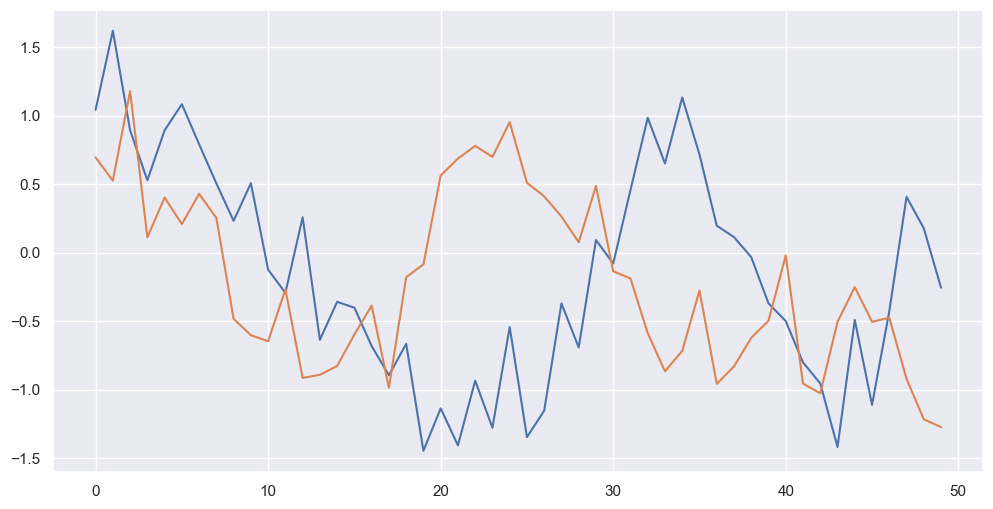

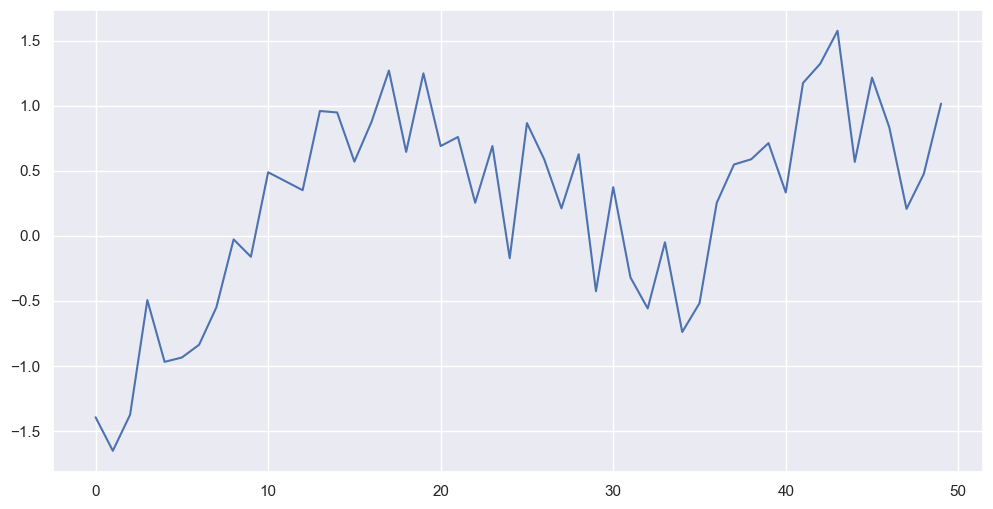

In [18]:
rnd = np.random.RandomState(42)
n = 50
d = 4
r = 2
T = np.linspace(1,10,n).reshape(-1,1)

kernel_true = gpflow.kernels.RBF(variance=1, lengthscales=1) + gpflow.kernels.White(variance=0.1)

K = kernel_true.K(T)#rbf_kernel(T,T, gamma = 0.1) + 0.01*np.identity(n)# linear_kernel(T,T)+ 0.001
K_inv = np.linalg.inv(K)
F_true = np.zeros((n, r))
for i in range(r):
    F_true[:,i] = rnd.multivariate_normal(mean = np.zeros(n), cov = K, size = 1)

fig, ax = plt.subplots()
ax.plot(F_true[:,0])
ax.plot(F_true[:,1])

# H_test = np.array([[0.4674319 , 0.25692823, 0.04447717, 0.01465488, 0.04447717,
#         0.17203065],
#        [0.25692823, 0.67356971, 0.00834163, 0.00202838, 0.00834163,
#         0.05079042],
#        [0.04447717, 0.00834163, 0.46111865, 0.21447944, 0.09323921,
#         0.17834389],
#        [0.01465488, 0.00202838, 0.21447944, 0.4674319 , 0.21447944,
#         0.08692596],
#        [0.04447717, 0.00834163, 0.09323921, 0.21447944, 0.46111865,
#         0.17834389],
#        [0.17203065, 0.05079042, 0.17834389, 0.08692596, 0.17834389,
#         0.33356518]])


H_test = np.identity(r)

scale = 0.1
psi = scale*np.identity(d)
psi_inv = np.linalg.inv(psi)
epsilon= rnd.normal(loc = 0, scale = scale, size = (n,d))
B_true = rnd.normal(loc = 0, scale = 1, size = (d,r))
Y_gp_true = np.dot(F_true, np.dot(H_test, B_true.T)) + epsilon
fig, ax = plt.subplots()
ax.plot(Y_gp_true[:,0])

In [19]:
shap_true = calc_shapley_value(B_true,None, Sigma= np.identity(B_true.shape[1]))
cov_outer_true = get_cov_outer(np.dot(B_true, H_test), F_true, scale, corr=False)
cov_true = get_cov(np.dot(B_true, H_test), F_true, scale, K)
cov_cond_true = get_cond_cov(B_true, F_true, scale, H_test, K)
cov_latent_cond_true = get_cond_cov(np.identity(r), F_true, scale, np.identity(r), K)

In [20]:
B_est, _,_ = get_params(Y_gp_true, F_true, n)
print(np.round(B_est, 2))
print(np.round(np.dot(B_true, H_test), 2))

[[-0.85 -0.58]
 [ 0.75  0.6 ]
 [-0.02  0.1 ]
 [ 1.26 -0.58]]
[[-0.83 -0.56]
 [ 0.75  0.61]
 [-0.02  0.12]
 [ 1.28 -0.59]]


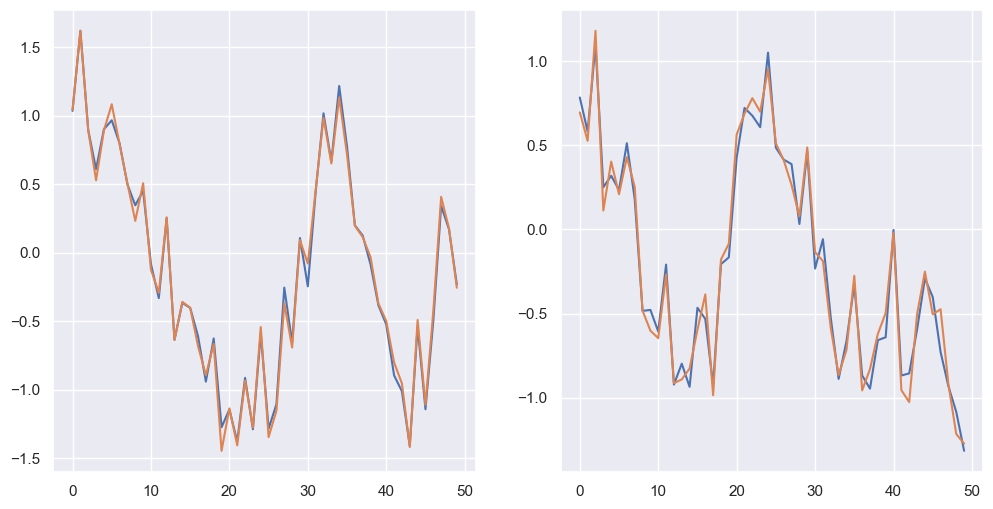

In [21]:
f_est = get_latent(B_true, K, Y_gp_true, scale, reg = 0)


fig, ax = plt.subplots(1,2)
ax[0].plot(f_est[:,0])
ax[0].plot(F_true[:,0])

ax[1].plot(f_est[:,1])
ax[1].plot(F_true[:,1])

## autograd optimization

In [22]:
from jax import value_and_grad
import jax.numpy as jnp
from jax.scipy.stats import multivariate_normal as mvn

def gp_ind_obj(param,Y,r, K, scale):

    d = Y.shape[1]
    n = Y.shape[0]



    B = param.reshape((d,r))


    #C = jnp.kron(jnp.dot(B,B.T), K) + scale*jnp.identity(n*d)
    #C_inv = jnp.linalg.inv(C)

    #v,_ = jnp.linalg.eigh(C)
    #v[v<= 0] = 1e-6
    #v.at[v<= 0].set(1e-6)

    #obj = -0.5*np.sum(np.log(v)) - 0.5*np.einsum('ij,ji->', C_inv, np.outer(Y.flatten(order='F'),Y.flatten(order='F')))
    #obj = -0.5*jnp.sum(jnp.log(v)) - 0.5*jnp.trace(jnp.dot(C_inv, jnp.outer(Y.flatten(order='F'),Y.flatten(order='F'))))


    cov_xx = K + (scale**2) * jnp.identity(n)
    cov = jnp.kron(jnp.dot(B,B.T), cov_xx) + 0.01 * jnp.identity(n*d)
    LL = mvn.logpdf(Y.flatten(order = 'F'), np.zeros(n*d), cov)

    return -LL#, -grad1.flatten()-grad2.flatten()


def get_latent(B_est, K, Y, scale, reg = 0):
    scale_sq = scale ** 2
    M = np.kron(np.dot(B_est.T, B_est), np.identity(n)) + scale_sq*np.kron(np.identity(r), np.linalg.inv(K))
    M_inv = np.linalg.inv(M + reg*np.identity(M.shape[0]))
    f_est = np.dot(M_inv, np.kron(B_est.T, np.identity(n))).dot(Y.flatten(order='F'))
    f_est = f_est.reshape((n,r), order = 'F')

    return f_est



In [23]:
out = minimize(value_and_grad(gp_ind_obj), np.random.uniform(size = d*r), args = (Y_gp_true,r, np.array(K), scale), jac = True, method= 'CG')
B_est_brute = out.x.reshape((d,r))

In [24]:
print(np.round(np.dot(B_est_brute,B_est_brute.T), 2))
print(np.round(np.dot(B_true,B_true.T), 2))

[[ 0.87 -0.81 -0.03 -0.67]
 [-0.81  0.75  0.03  0.58]
 [-0.03  0.03  0.01 -0.05]
 [-0.67  0.58 -0.05  1.39]]
[[ 1.   -0.96 -0.05 -0.73]
 [-0.96  0.93  0.06  0.59]
 [-0.05  0.06  0.01 -0.1 ]
 [-0.73  0.59 -0.1   1.98]]


In [25]:
f_est_brute = get_latent(B_est_brute, K, Y_gp_true, scale)#[:,::-1]

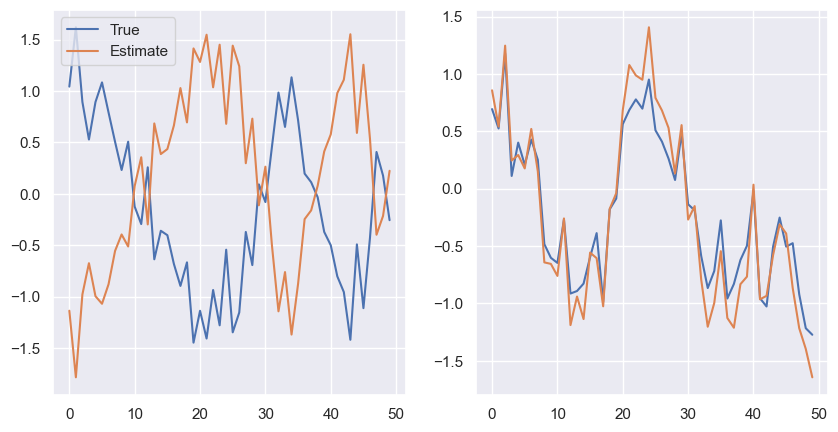

In [26]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(F_true[:,0], label = 'True')
ax[0].plot(-f_est_brute[:,1], label = 'Estimate')
ax[0].legend()

ax[1].plot(F_true[:,1])
ax[1].plot(-f_est_brute[:,0])


Get covariance

In [296]:

shap_brute = calc_shapley_value(B_est_brute,None, Sigma= np.identity(B_est_brute.shape[1]))
cov_brute = get_cov(B_est_brute,f_est_brute, scale, K)
cov_outer_brute = get_cov_outer(B_est_brute, f_est_brute, scale, corr=False)
cov_cond_brute = get_cond_cov(B_est_brute, f_est_brute, scale, H_test, K)
cov_latent_cond_brute = get_cond_cov(np.identity(r), f_est_brute, scale, np.identity(r), K)


In [286]:
print(np.round(shap_brute,2))
print("")
print(np.round(shap_true,2))

[[ 0.87  1.12]
 [-1.11  0.8 ]
 [ 0.74 -0.74]
 [ 0.89 -0.75]
 [ 1.42  0.56]
 [-0.95 -0.53]
 [-1.13 -0.53]
 [ 0.63  0.49]
 [ 0.76  0.5 ]
 [ 0.91  0.51]]

[[ 3.64  0.74]
 [ 0.79 -1.62]
 [-1.06  1.15]
 [-0.93  1.33]
 [ 0.17  3.56]
 [-0.23 -2.52]
 [-0.2  -2.92]
 [ 0.31  1.78]
 [ 0.27  2.07]
 [ 0.24  2.39]]


In [287]:
print(np.round(cov_brute[8],2))
print("")
print(np.round(cov_true[8],2))

[[ 1.   -0.16 -0.    0.08]
 [-0.16  1.   -0.98 -0.99]
 [-0.   -0.98  1.    0.99]
 [ 0.08 -0.99  0.99  1.  ]]

[[ 1.   -0.21  0.03  0.12]
 [-0.21  1.   -0.98 -0.99]
 [ 0.03 -0.98  1.    0.99]
 [ 0.12 -0.99  0.99  1.  ]]


In [197]:
print(np.round(cov_outer_brute[8],2))
print("")
print(np.round(cov_outer_true[8],2))

[[ 5.57  3.6  -3.43 -3.44]
 [ 3.6   2.34 -2.22 -2.23]
 [-3.43 -2.22  2.12  2.12]
 [-3.44 -2.23  2.12  2.14]]

[[ 5.2   3.55 -3.37 -3.38]
 [ 3.55  2.43 -2.3  -2.31]
 [-3.37 -2.3   2.19  2.19]
 [-3.38 -2.31  2.19  2.21]]


In [200]:
print(np.round(cov_cond_brute[8],2))
print("")
print(np.round(cov_cond_true[8],2))

[[ 1.   -0.11 -0.01  0.05]
 [-0.11  1.   -0.67 -0.71]
 [-0.01 -0.67  1.    0.65]
 [ 0.05 -0.71  0.65  1.  ]]

[[ 1.   -0.17  0.02  0.09]
 [-0.17  1.   -0.78 -0.81]
 [ 0.02 -0.78  1.    0.77]
 [ 0.09 -0.81  0.77  1.  ]]


In [289]:
cov_cond_brute[8].shape

(4, 4)

In [27]:

shap_tmp_brute = calc_shapley_value(B_est_brute, None, Sigma= cov_latent_cond_brute[8])
shap_tmp_true = calc_shapley_value(B_true, None, Sigma= cov_latent_cond_true[8])
print(np.round(shap_tmp_brute,2))
print("")
print(np.round(shap_tmp_true,2))

NameError: name 'cov_latent_cond_brute' is not defined

Looks lala

## Estimate using coregonalization python

In [28]:
X_augmented = []
for i in range(d):
    X_augmented.append(np.hstack((T, i * np.ones_like(T))))
X_augmented = np.vstack(X_augmented)

Y_augmented = []
for i in range(d):
    Y_augmented.append(np.hstack((Y_gp_true[:,i].reshape(-1,1), i * np.ones_like(Y_gp_true[:,i].reshape(-1,1)))))
Y_augmented = np.vstack(Y_augmented)



share svgp

In [30]:
nr_induce = 50


k_shared = gpflow.kernels.RBF() + gpflow.kernels.White(variance=0.1)
#gpflow.set_trainable(k_shared, False)
#gpflow.set_trainable(k_shared, False)
#k_shared.kernels[0].variance = np.float64(1)
#k_shared.kernels[0].lengthscales = np.float64(1)
#k_shared.kernels[1].variance = np.float64(0.1)

kern_list = [k_shared for _ in range(r)]
# Create multi-output kernel from kernel list
kernel = gpflow.kernels.LinearCoregionalization(
    kern_list, W=np.random.randn(d, r)
)


Zinit = np.linspace(np.min(T),np.min(T) ,nr_induce)

Z = Zinit.copy().reshape(-1,1)
# create multi-output inducing variables from Z
iv = gpflow.inducing_variables.SharedIndependentInducingVariables(
    gpflow.inducing_variables.InducingPoints(Z)
)
# initialize mean of variational posterior to be of shape MxL
q_mu = np.zeros((nr_induce, r))
# initialize \sqrt(Σ) of variational posterior to be of shape LxMxM
q_sqrt = np.repeat(np.eye(nr_induce)[None, ...], r, axis=0) * 1.0

# create SVGP model as usual and optimize
likelihood = gpflow.likelihoods.Gaussian()
m_svgp = gpflow.models.SVGP(
    kernel, likelihood, inducing_variable=iv, q_mu=q_mu, q_sqrt=q_sqrt
)


print(m_svgp.kernel.W)

def optimize_model_with_scipy(model):
    optimizer = gpflow.optimizers.Scipy()
    optimizer.minimize(
        model.training_loss_closure((T, Y_gp_true)),
        variables=model.trainable_variables,
        method="l-bfgs-b",
        options={"disp": True, "maxiter": 5000},
    )


optimize_model_with_scipy(m_svgp)


print(m_svgp.kernel.W)
print(B_true)


<Parameter: name=identity, dtype=float64, shape=[4, 2], fn="identity", numpy=
array([[-2.42667924, -0.42891263],
       [ 1.26593626, -0.8667404 ],
       [-0.67888615, -0.09470897],
       [ 1.49138963, -0.638902  ]])>
Instructions for updating:
Use fn_output_signature instead
<Parameter: name=identity, dtype=float64, shape=[4, 2], fn="identity", numpy=
array([[-0.21916767, -0.12279592],
       [ 0.19322382,  0.12722093],
       [-0.01314944,  0.02829964],
       [ 0.39384434, -0.12974977]])>
[[-0.82899501 -0.56018104]
 [ 0.74729361  0.61037027]
 [-0.02090159  0.11732738]
 [ 1.2776649  -0.59157139]]


In [43]:

print(np.round(np.array(m_svgp.kernel.W),2))
print("")
print(np.round(B_true, 2))

[[-0.22 -0.12]
 [ 0.19  0.13]
 [-0.01  0.03]
 [ 0.39 -0.13]]

[[-0.83 -0.56]
 [ 0.75  0.61]
 [-0.02  0.12]
 [ 1.28 -0.59]]


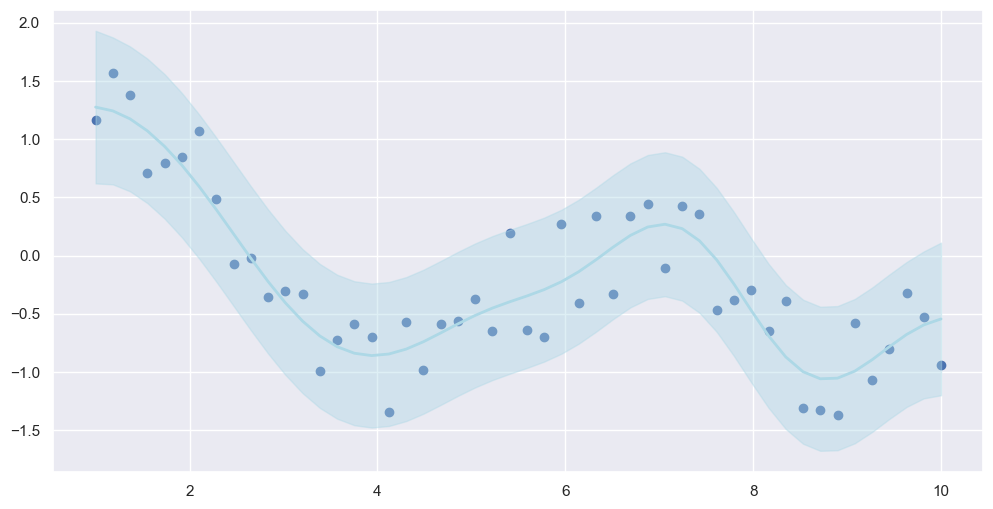

In [44]:


fig, ax = plt.subplots(1,1)
i = 1
ax.scatter(T[:,0], Y_gp_true[:,i])
mu, var = m_svgp.predict_y(T)
plot_gp(T, mu[:,i][:,np.newaxis], var[:,i][:,np.newaxis], 'lightblue', "Y1", ax)

In [45]:
m_svgp.kernel.W

<Parameter: name=identity, dtype=float64, shape=[4, 2], fn="identity", numpy=
array([[-0.21916767, -0.12279592],
       [ 0.19322382,  0.12722093],
       [-0.01314944,  0.02829964],
       [ 0.39384434, -0.12974977]])>

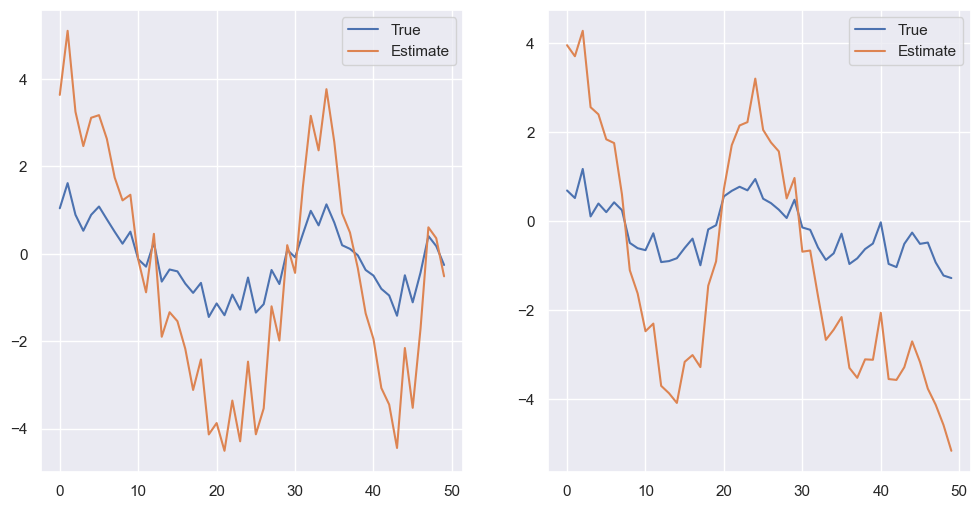

In [46]:

F_est =get_latent(np.array(m_svgp.kernel.W), np.array(kernel_true.K(T)), Y_gp_true, scale)

fig, ax = plt.subplots(1,2)
ax[0].plot(F_true[:,0], label = 'True')
ax[0].plot(F_est[:,0], label = 'Estimate')
ax[0].legend()

ax[1].plot(F_true[:,1], label = 'True')
ax[1].plot(F_est[:,1], label = 'Estimate')
ax[1].legend()


In [52]:
output_dim = d  # Number of outputs
rank = r  # Rank of W

# Base kernel
k = gpflow.kernels.RBF(active_dims=[0]) +  gpflow.kernels.White(variance=0.1)
#gpflow.set_trainable(k.variance, False)
#gpflow.set_trainable(k.lengthscales, False)
#k.variance = np.float64(1)
#k.lengthscales = np.float64(1)

# Coregion kernel
coreg = gpflow.kernels.Coregion(output_dim=output_dim, rank=rank, active_dims=[1])
coreg.W = np.random.uniform(size = (d,r))
gpflow.set_trainable(coreg.kappa, False)
coreg.kappa = np.array([0.001]*d)

kern = k * coreg


shared_lik = gpflow.likelihoods.Gaussian()
lik = gpflow.likelihoods.SwitchedLikelihood(
    [shared_lik] * d
)

# now build the GP model as normal
m = gpflow.models.VGP((X_augmented, Y_augmented), kernel=kern, likelihood=lik)

# fit the covariance function parameters
maxiter = 100
gpflow.optimizers.Scipy().minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=maxiter),
    method="L-BFGS-B",
)



  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 167.4065593554331
        x: [-3.079e-01  8.259e-02 ... -5.867e+00 -1.665e+00]
      nit: 100
      jac: [-7.830e-01 -1.986e+00 ...  4.323e-01 -2.755e-01]
     nfev: 104
     njev: 104
 hess_inv: <20304x20304 LbfgsInvHessProduct with dtype=float64>

In [54]:
print(np.round(coreg.W, 2))
print("")
print(np.round(B_true, 2))

[[0.62 0.12]
 [0.32 0.41]
 [0.87 0.25]
 [0.48 0.99]]

[[-0.83 -0.56]
 [ 0.75  0.61]
 [-0.02  0.12]
 [ 1.28 -0.59]]


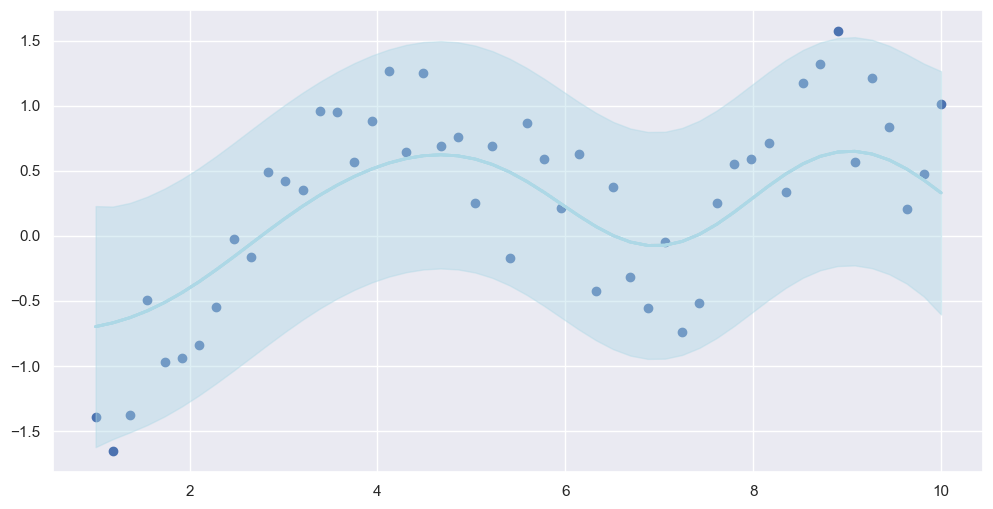

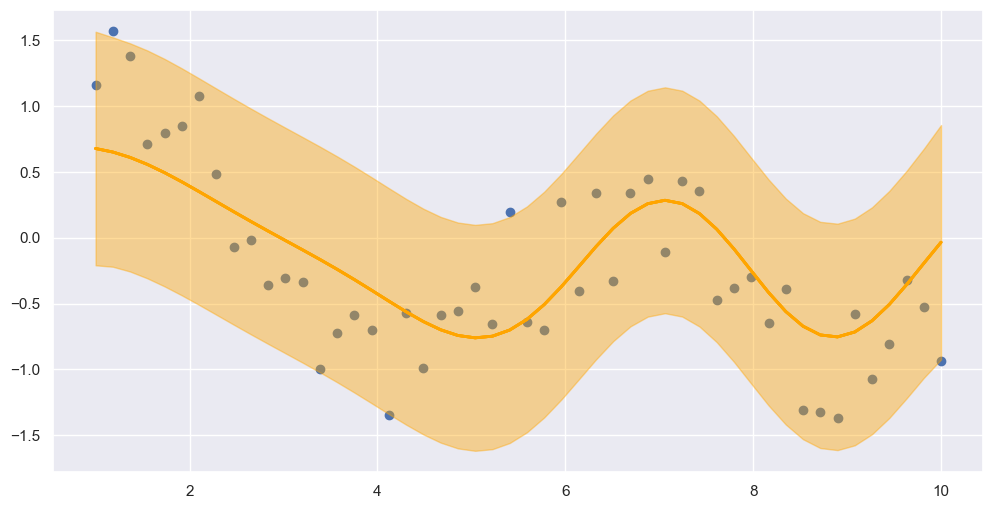

In [55]:


fig, ax = plt.subplots(1,1)
ax.scatter(T[:,0], Y_gp_true[:,0])
mu, var = m.predict_y(np.hstack((T, 0 * np.zeros_like(T))))
plot_gp(T, mu, var, 'lightblue', "Y1", ax)

fig, ax = plt.subplots(1,1)
ax.scatter(T[:,0], Y_gp_true[:,1])
mu, var = m.predict_y(np.hstack((T, 1 * np.ones_like(T))))
plot_gp(T, mu, var, 'orange', "Y2", ax)

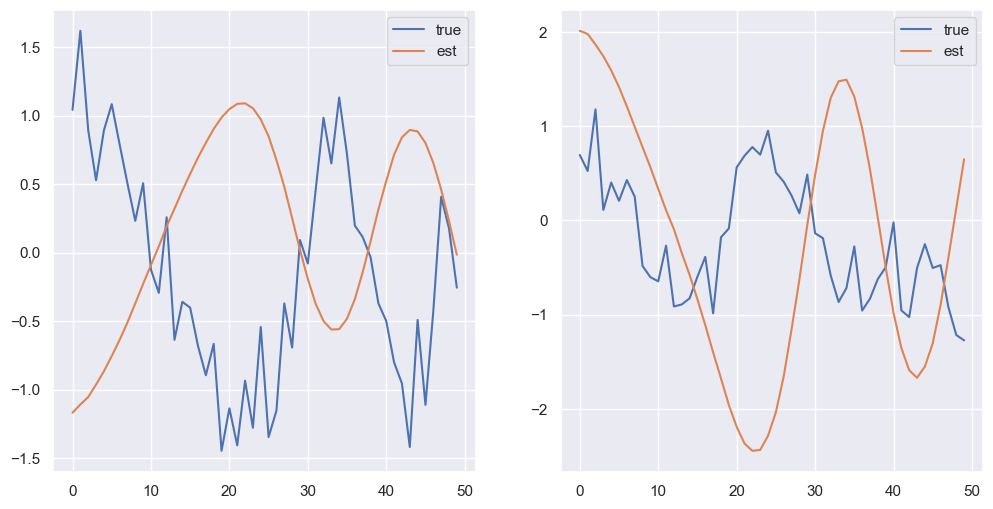

In [57]:


F_est =get_latent(np.array(coreg.W), np.array(k.K(T)), Y_gp_true, np.sqrt(np.array(shared_lik.variance)))

fig, ax = plt.subplots(1,2)
ax[0].plot(F_true[:,0], label = 'true')
ax[0].plot(F_est[:,0], label = 'est')
ax[0].legend()

ax[1].plot(F_true[:,1], label = 'true')
ax[1].plot(F_est[:,1], label = 'est')
ax[1].legend()


## GP LVM

In [220]:
from gpflow.utilities import ops, print_summary
from gpflow.config import set_default_float, default_float, set_default_summary_fmt

num_inducing = 15
X_var_init = tf.ones((n, r), dtype=default_float())

X_mean_init = ops.pca_reduce(Y_gp_true, r)
inducing_variable = tf.convert_to_tensor(
    np.random.permutation(X_mean_init.numpy())[:num_inducing], dtype=default_float()
)

lengthscales = tf.convert_to_tensor([1.0] * r, dtype=default_float())
kernel_gplvm = gpflow.kernels.Linear(variance=1) #gpflow.kernels.RBF(lengthscales=lengthscales)
gpflow.set_trainable(kernel_gplvm.variance, False)
kernel_gplvm.variance = np.float64(1)

gplvm = gpflow.models.BayesianGPLVM(
    Y_gp_true,
    X_data_mean=X_mean_init,
    X_data_var=X_var_init,
    kernel=kernel_gplvm,
    inducing_variable=inducing_variable,
)


opt = gpflow.optimizers.Scipy()
maxiter = 100
_ = opt.minimize(
    gplvm.training_loss,
    method="BFGS",
    variables=gplvm.trainable_variables,
    options=dict(maxiter=maxiter),
)

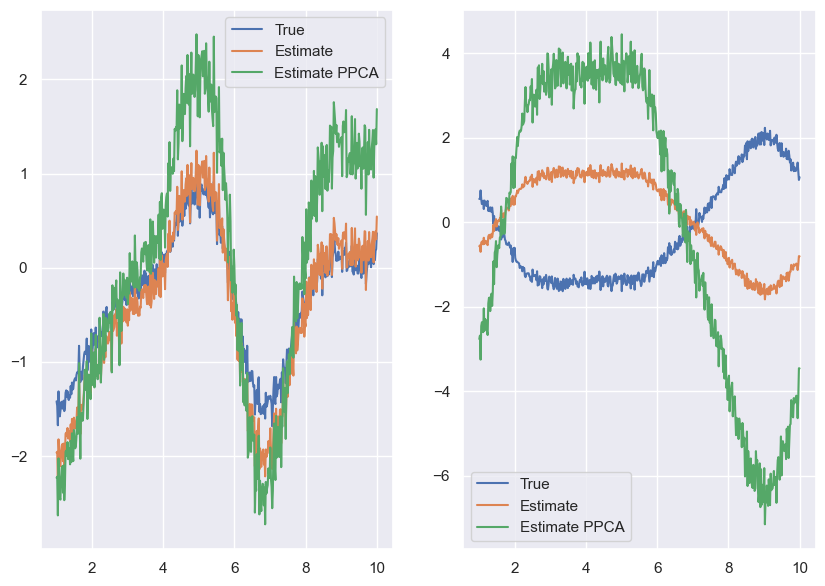

In [221]:
fig, ax = plt.subplots(1,2, figsize = (10,7))


ax[0].plot(T[:,0], F_true[:,0], label = 'True')
ax[0].plot(T[:,0], gplvm.X_data_mean.numpy()[:,0], label = 'Estimate')
ax[0].plot(T[:,0], X_mean_init[:,0], label = 'Estimate PPCA')
ax[0].legend()



ax[1].plot(T[:,0], F_true[:,1], label = 'True')
ax[1].plot(T[:,0], gplvm.X_data_mean.numpy()[:,1], label = 'Estimate')
ax[1].plot(T[:,0], X_mean_init[:,1], label = 'Estimate PPCA')
ax[1].legend()

In [11]:
B_est, _,_ = get_params(Y_gp_true, gplvm.X_data_mean.numpy())
print(np.round(B_est, 2))
print(np.round(B_true, 2))

NameError: name 'gplvm' is not defined

In [222]:
def GP_LVM_linear(Y, scale, r):
    d = Y.shape[1]

    U, S, Vh = np.linalg.svd(np.dot(Y,Y.T))
    L = (S[:r]/d-scale**2) ** (-0.5)

    return np.dot(U[:,:r], np.diag(L))
    



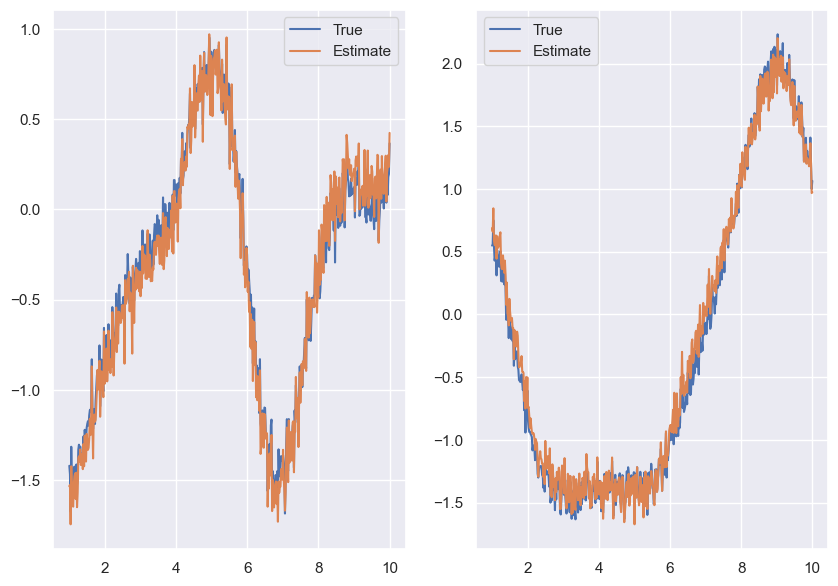

In [263]:
F_est_gplvm_linear = GP_LVM_linear(Y_gp_true, scale, r)
F_est_gplvm_linear = F_est_gplvm_linear#[:,::-1]


fig, ax = plt.subplots(1,2, figsize = (10,7))

ax[0].plot(T[:,0], F_true[:,0], label = 'True')
ax[0].plot(T[:,0], 300*F_est_gplvm_linear[:,1], label = 'Estimate')
#ax[0].plot(T[:,0], X_mean_init[:,0], label = 'Estimate PPCA')
ax[0].legend()


ax[1].plot(T[:,0], F_true[:,1], label = 'True')
ax[1].plot(T[:,0], -1100*F_est_gplvm_linear[:,0], label = 'Estimate')
#ax[1].plot(T[:,0], X_mean_init[:,1], label = 'Estimate PPCA')
ax[1].legend()



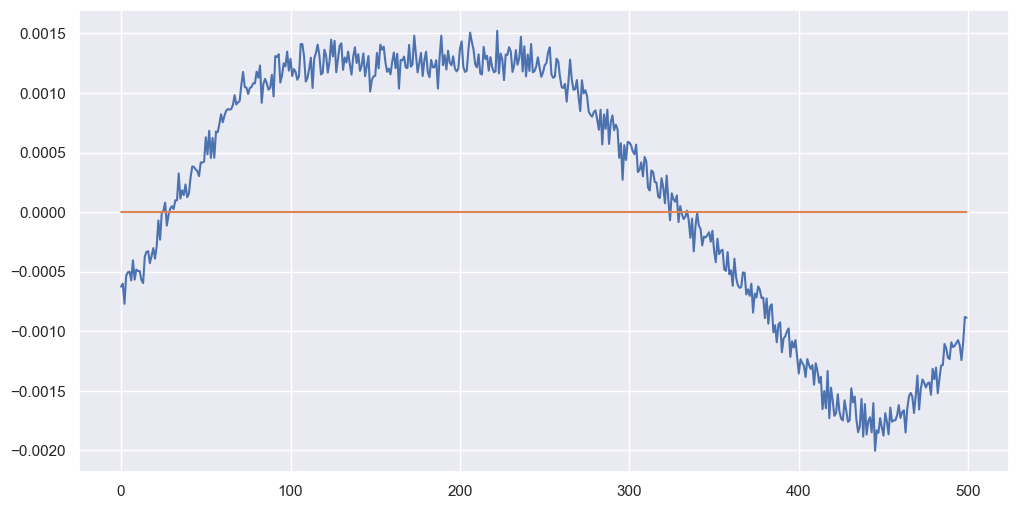

In [318]:
plt.plot(F_est_gplvm_linear[:,0].reshape(-1,1))
plt.plot(f_var)

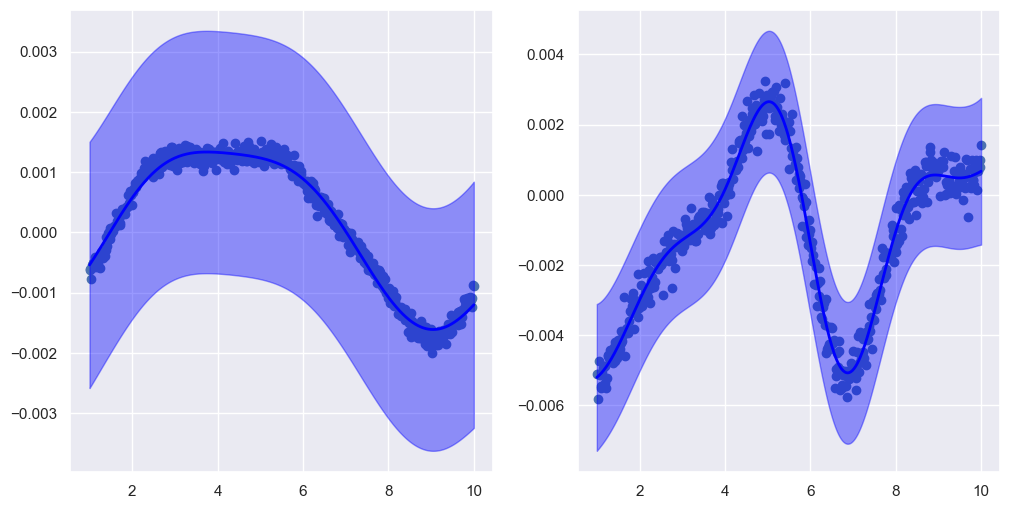

In [323]:
F_gplvm_fitted_gp = np.ones((n, r))
gp_for_gplvm = []

for i in range(r):
    model = gpflow.models.GPR(
    (T, F_est_gplvm_linear[:,i][:,np.newaxis]),
    kernel=gpflow.kernels.SquaredExponential())
    
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    gp_for_gplvm.append(model)
    f_mean, f_var = model.predict_y(T, full_cov=False)
    F_gplvm_fitted_gp[:,i] = f_mean[:,0]



fig , ax = plt.subplots(1,2)

ax[0].scatter(T[:,0], F_est_gplvm_linear[:,0])
f_mean, f_var = gp_for_gplvm[0].predict_y(T, full_cov=False)
plot_gp(T, f_mean, f_var, 'blue', 'fitted_gplvm', ax[0])

ax[1].scatter(T[:,0], F_est_gplvm_linear[:,1])
f_mean, f_var = gp_for_gplvm[1].predict_y(T, full_cov=False)
plot_gp(T, f_mean, f_var, 'blue', 'fitted_gplvm', ax[1])


In [264]:
#F_est_gplvm_linear[:,0] = -1100*F_est_gplvm_linear[:,0]
#F_est_gplvm_linear[:,1] = 300*F_est_gplvm_linear[:,1]

B_est_gplvm_linear, _,_ = get_params(Y_gp_true, F_est_gplvm_linear, n)
print(np.round(1e-6*np.dot(B_est_gplvm_linear, B_est_gplvm_linear.T), 2))
print(np.round(np.dot(B_true,B_true.T), 2))

[[ 1.09 -1.83  1.26  1.49]
 [-1.83  4.55 -3.25 -3.76]
 [ 1.26 -3.25  2.33  2.69]
 [ 1.49 -3.76  2.69  3.11]]
[[ 4.38 -0.84  0.09  0.4 ]
 [-0.84  3.73 -2.75 -3.12]
 [ 0.09 -2.75  2.09  2.34]
 [ 0.4  -3.12  2.34  2.63]]


In [265]:
cov_outer_linear_gplvm = get_cov_outer(B_est_gplvm_linear,F_est_gplvm_linear, scale, corr=False)
cov_linear_gplvm = get_cov(B_est_gplvm_linear,F_est_gplvm_linear, scale, K)
cov_cond_linear_gplvm = get_cond_cov(B_est_gplvm_linear, F_est_gplvm_linear, scale, H_test, K)

In [261]:
print(np.round(cov_outer_true[3],2))
print("")
print(np.round(cov_outer_linear_gplvm[3],2))

[[ 4.19  3.2  -2.97 -3.02]
 [ 3.2   2.46 -2.28 -2.31]
 [-2.97 -2.28  2.13  2.15]
 [-3.02 -2.31  2.15  2.19]]

[[ 5.04  3.28 -3.12 -3.13]
 [ 3.28  2.15 -2.04 -2.04]
 [-3.12 -2.04  1.94  1.94]
 [-3.13 -2.04  1.94  1.96]]


In [266]:
print(np.round(cov_true[3],2))
print("")
print(np.round(cov_linear_gplvm[3],2))

[[ 1.   -0.21  0.03  0.12]
 [-0.21  1.   -0.98 -0.99]
 [ 0.03 -0.98  1.    0.99]
 [ 0.12 -0.99  0.99  1.  ]]

[[ 1.   -0.82  0.79  0.81]
 [-0.82  1.   -1.   -1.  ]
 [ 0.79 -1.    1.    1.  ]
 [ 0.81 -1.    1.    1.  ]]


In [324]:
print(np.round(cov_cond_true[3],2))
print("")
print(np.round(cov_cond_linear_gplvm[3],2))

[[ 1.   -0.17  0.02  0.09]
 [-0.17  1.   -0.79 -0.82]
 [ 0.02 -0.79  1.    0.77]
 [ 0.09 -0.82  0.77  1.  ]]

[[ 1.   -0.82  0.79  0.81]
 [-0.82  1.   -1.   -1.  ]
 [ 0.79 -1.    1.    1.  ]
 [ 0.81 -1.    1.    1.  ]]


# With Graph Strucutre

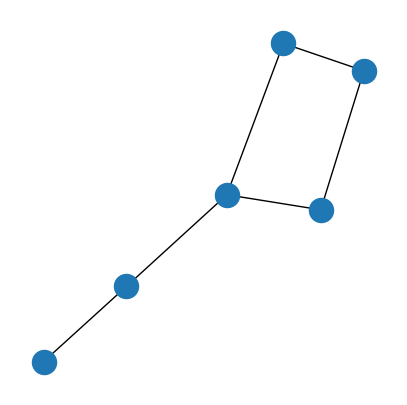

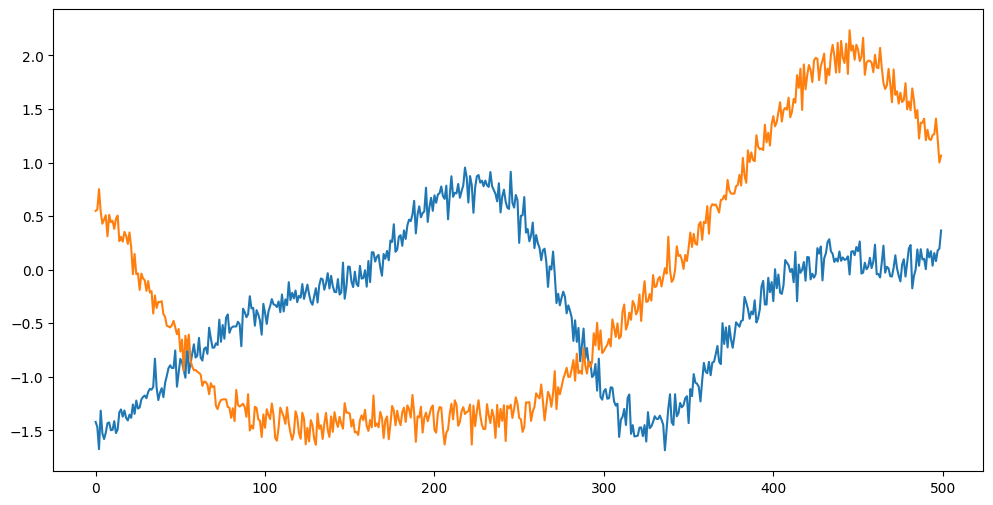

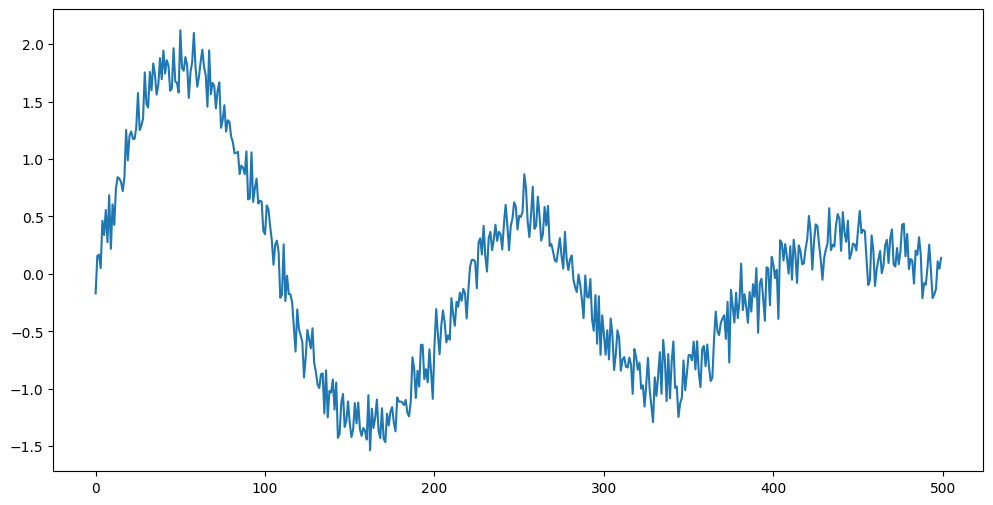

In [28]:
import networkx as nx

rnd = np.random.RandomState(42)
n_graph = 500
d_graph = 10
r_graph = 6
T_graph = np.linspace(1,10,n_graph).reshape(-1,1)

kernel_graph_true = gpflow.kernels.RBF(variance=1, lengthscales=1) + gpflow.kernels.White(variance=0.01)

K_graph = kernel_true.K(T_graph)#rbf_kernel(T,T, gamma = 0.1) + 0.01*np.identity(n)# linear_kernel(T,T)+ 0.001
K_graph_inv = np.linalg.inv(K_graph)
F_graph_true = np.zeros((n_graph, r_graph))
for i in range(r_graph):
    F_graph_true[:,i] = rnd.multivariate_normal(mean = np.zeros(n_graph), cov = K_graph, size = 1)



G = nx.fast_gnp_random_graph(r_graph, 2/r_graph,    seed = 1)

fig, ax = plt.subplots(1,1, figsize = (5,5))
nx.draw(G, ax = ax)

v, u = np.linalg.eigh(nx.laplacian_matrix(G).todense())
beta = 0.5
H = np.array(np.dot(u, np.diag(np.exp(-beta*v))).dot(u.T))
H_sq = np.dot(H,H)
H_sq_inv = np.linalg.inv(H_sq)

fig, ax = plt.subplots()
ax.plot(F_graph_true[:,0])
ax.plot(F_graph_true[:,1])

scale_graph = 0.1
psi = scale_graph*np.identity(d_graph)
psi_inv = np.linalg.inv(psi)
epsilon= rnd.normal(loc = 0, scale = scale_graph, size = (n_graph,d_graph))
B_graph_true = rnd.normal(loc = 0, scale = 1, size = (d_graph,r_graph))
Y_gp_graph_true = np.dot(F_graph_true, np.dot(H, B_graph_true.T)) + epsilon
fig, ax = plt.subplots()
ax.plot(Y_gp_graph_true[:,0])



In [39]:
cov_true_graph = get_cov(np.dot(B_graph_true, H), F_graph_true, scale=scale_graph)

In [ ]:
# rnd = np.random.RandomState(42)


# n_graph = 500
# d_graph = 4
# r_graph = 3
# beta = 0.5
# G = nx.fast_gnp_random_graph(r_graph, 2/r_graph,    seed = 1)

# fig, ax = plt.subplots(1,1, figsize = (5,5))
# nx.draw(G, ax = ax)

# v, u = np.linalg.eigh(nx.laplacian_matrix(G).todense())

# H = np.array(np.dot(u, np.diag(np.exp(-beta*v))).dot(u.T))
# H_sq = np.dot(H,H)
# H_sq_inv = np.linalg.inv(H_sq)


# #T  = np.random.normal(loc = 0, scale = 1, size = (n,r)) 
# T = np.linspace(1,10,n_graph).reshape(-1,1)
# kernel_graph_true = gpflow.kernels.RBF(variance=1, lengthscales=1) + gpflow.kernels.White(variance=0.1)# rbf_kernel(T,T, gamma = 0.01) + 0.000001*np.identity(n)# linear_kernel(T,T)+ 0.001*np.identity(n)# rbf_kernel(T,T, gamma = 0.1) + 0.001*np.identity(n)
# K_graph = kernel_graph_true.K(T)
# K_graph_inv = np.linalg.inv(K_graph)
# # print(K[:,0])

# omega = 1
# F_true_graph = matrix_normal(rowcov = K_graph, colcov = np.dot(H,H)*(1/omega), seed =1).rvs()

# scale = 0.1
# psi_true_graph = scale*np.identity(d_graph)
# psi_inv_true_graph = np.linalg.inv(psi_true_graph)


# epsilon= rnd.normal(loc = 0, scale = scale, size = (n_graph,d_graph))
# #B_true = np.random.normal(loc = 0, scale = 0, size = (d,r))
# #A_true = np.random.normal(loc = 0, scale = 0, size = (d,r))
# P = rnd.binomial(1,0.5,size = (d_graph,r_graph) )
# #A_true = rnd.uniform(-1,1,size = (d,r))
# #A_true[A_true <0.5] = 0
# B_true_graph = rnd.uniform(-1,1,size = (d_graph,r_graph))
# B_true_graph[np.abs(B_true_graph)<0.3] = 0#*(np.random.uniform(size = (d,r) ) <0.5)

# A_true = np.zeros(shape = (d_graph,r_graph))

# #Y = np.dot(F_true, A_true.T) +  gamma[:, np.newaxis]*np.dot(F_true, B_true.T) + epsilon
# Y_graph =np.dot(F_true_graph, B_true_graph.T) + epsilon

# fig, ax = plt.subplots(3,2, figsize = (10,5))
# for i in range(r):
#     idx = i % 2
#     jdx = i % 3
#     ax[jdx,idx].plot(F_true_graph[:,i])

# #ax.plot(multivariate_normal.rvs(cov = rbf_kernel(np.linspace(1,10,100).reshape(-1,1),np.linspace(1,10,100).reshape(-1,1), gamma = 0.1)))


In [40]:
F_est_graph_gplvm_linear = GP_LVM_linear(Y_gp_graph_true, scale, r_graph)
# F_est_graph_gplvm_linear = F_est_graph_gplvm_linear[:,::-1]
#F_est_graph_gplvm_linear = np.dot(F_est_graph_gplvm_linear, H)

In [41]:
F_graph_fitted = np.ones((n_graph, r_graph))

for i in range(r_graph):
    model = gpflow.models.GPR(
    (T, F_est_graph_gplvm_linear[:,i][:,np.newaxis]),
    kernel=gpflow.kernels.SquaredExponential())
    
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    f_mean, f_var = model.predict_y(T, full_cov=False)
    F_graph_fitted[:,i] = f_mean[:,0]





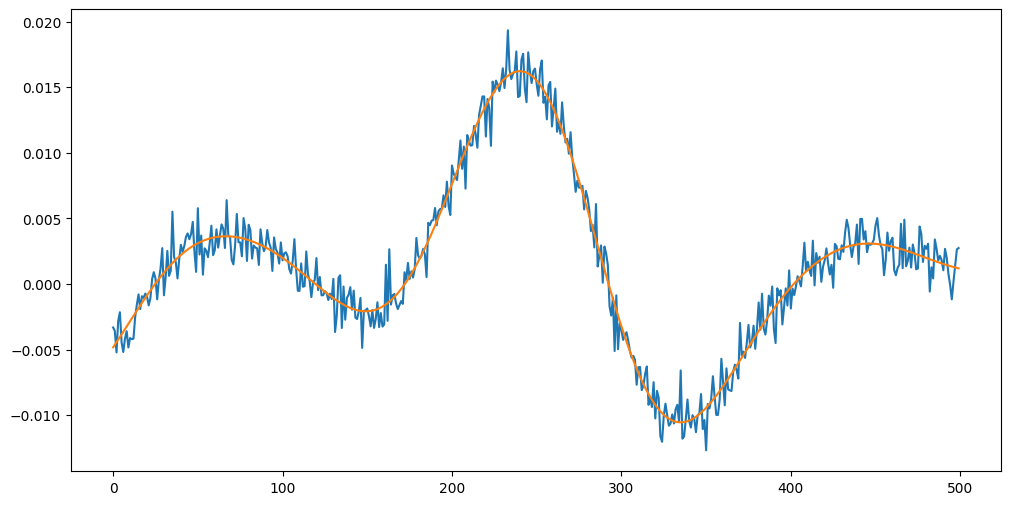

In [42]:
plt.plot(F_est_graph_gplvm_linear[:,2])
plt.plot(F_graph_fitted[:,2])

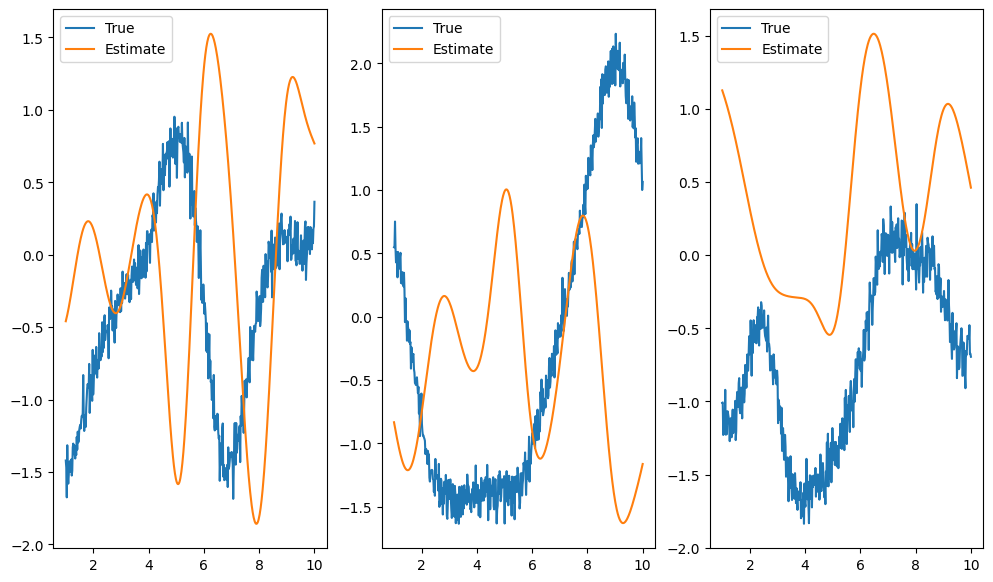

In [43]:
fig, ax = plt.subplots(1,3, figsize = (12,7))
F_graph_fitted_corr = np.dot(F_graph_fitted, H)[:,::-1]

ax[0].plot(T[:,0], F_graph_true[:,0], label = 'True')
ax[0].plot(T[:,0], -100*F_graph_fitted_corr[:,0], label = 'Estimate')
#ax[0].plot(T[:,0], X_mean_init[:,0], label = 'Estimate PPCA')
ax[0].legend()


ax[1].plot(T[:,0], F_graph_true[:,1], label = 'True')
ax[1].plot(T[:,0], 100*F_graph_fitted_corr[:,1], label = 'Estimate')
#ax[1].plot(T[:,0], X_mean_init[:,1], label = 'Estimate PPCA')
ax[1].legend()


ax[2].plot(T[:,0], F_graph_true[:,2], label = 'True')
ax[2].plot(T[:,0], -100*F_graph_fitted_corr[:,2], label = 'Estimate')
#ax[1].plot(T[:,0], X_mean_init[:,1], label = 'Estimate PPCA')
ax[2].legend()

In [44]:
B_est_linear_gplvm_g, _,_ = get_params(Y_gp_graph_true, F_est_graph_gplvm_linear, n_graph)
cov_linear_gplvm_g = get_cov(B_est_linear_gplvm_g, F_est_graph_gplvm_linear, scale=scale_graph)
#print(np.round(B_est, 2))
#print(np.round(B_true, 2))

In [47]:
print(np.round(cov_linear_gplvm_g[5], 2))

[[ 0.13 -0.14  0.03 -0.24  0.64 -0.39  0.34  0.08  0.45  0.18]
 [-0.14  0.18 -0.03  0.29 -0.77  0.47 -0.4  -0.1  -0.54 -0.22]
 [ 0.03 -0.03  0.02 -0.06  0.16 -0.09  0.08  0.02  0.11  0.04]
 [-0.24  0.29 -0.06  0.49 -1.3   0.79 -0.68 -0.16 -0.9  -0.37]
 [ 0.64 -0.77  0.16 -1.3   3.52 -2.13  1.84  0.44  2.44  1.  ]
 [-0.39  0.47 -0.09  0.79 -2.13  1.3  -1.12 -0.27 -1.48 -0.61]
 [ 0.34 -0.4   0.08 -0.68  1.84 -1.12  0.97  0.23  1.28  0.52]
 [ 0.08 -0.1   0.02 -0.16  0.44 -0.27  0.23  0.07  0.31  0.13]
 [ 0.45 -0.54  0.11 -0.9   2.44 -1.48  1.28  0.31  1.71  0.69]
 [ 0.18 -0.22  0.04 -0.37  1.   -0.61  0.52  0.13  0.69  0.29]]


In [48]:
print(np.round(cov_true_graph[5], 2))


[[ 0.24 -0.13  0.04 -0.3   0.86 -0.54  0.46  0.1   0.61  0.25]
 [-0.13  0.08 -0.02  0.17 -0.48  0.3  -0.26 -0.05 -0.34 -0.14]
 [ 0.04 -0.02  0.02 -0.06  0.17 -0.1   0.09  0.02  0.12  0.05]
 [-0.3   0.17 -0.06  0.42 -1.16  0.72 -0.62 -0.13 -0.82 -0.34]
 [ 0.86 -0.48  0.17 -1.16  3.3  -2.05  1.76  0.37  2.31  0.96]
 [-0.54  0.3  -0.1   0.72 -2.05  1.28 -1.09 -0.23 -1.44 -0.6 ]
 [ 0.46 -0.26  0.09 -0.62  1.76 -1.09  0.95  0.2   1.24  0.51]
 [ 0.1  -0.05  0.02 -0.13  0.37 -0.23  0.2   0.05  0.26  0.11]
 [ 0.61 -0.34  0.12 -0.82  2.31 -1.44  1.24  0.26  1.63  0.67]
 [ 0.25 -0.14  0.05 -0.34  0.96 -0.6   0.51  0.11  0.67  0.29]]
